# Paper analysis

## Setup

### Load libraries

In [70]:
library(tidyverse)
library(wesanderson)
library(gridExtra)
library(ggforce)

In [71]:
pal <- wes_palettes$"BottleRocket2"
colors <- pal[1:4]
popcolors <- c('#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00')

### Define useful functions

In [72]:
wrap_by <- function(...) {
  facet_wrap(vars(...), labeller = label_both)
}

In [73]:
computePower <- function( quantile, null, empirical ){
    null <- rev(null)
    sum(empirical > null[quantile] ) / length(empirical)
}

In [74]:
computeROC <- function( input_df, mcoef ){
    # compute Smax df
    max_stats<- input_df %>% 
        filter(m==mcoef) %>%
        group_by( replicate, covariance, s ) %>%
        summarise(Smax=max(hapflk))
    # Define global variables
    null_global <- max_stats %>% filter(s==0) 
    selection_global <- max_stats %>% filter(s!=0) 
    alpha <- seq(0,1,0.01)
    quantiles <- 1:length(alpha)
    # Allocate dataframe
    
    df <- data.frame(alpha) %>% as_tibble()
    # Define groupings
    covariances <- max_stats %>%
        dplyr::select(covariance) %>%
        distinct() %>%
        pull(covariance)
    
    
    for ( i in covariances ){
        
        null <- null_global %>%
            filter(covariance == i ) %>%
            pull(Smax)
        selection <- selection_global %>%
            filter(covariance == i ) %>%
            pull(Smax)
        
        qnull <- quantile(null, probs = alpha )
        power <- sapply(quantiles,
                        FUN = computePower,
                        empirical = selection,
                        null = qnull )
        
        df[i] <- power
        
    }
    
    
    df <- df %>%
        pivot_longer(cols = all_of(covariances),
                     names_to = "covariance",
                     values_to = "power"
        )
    
    return(df)
    
}

In [75]:
plotROC <- function(df, mcoef){
    
    auc <- df %>%
        group_by(covariance) %>% 
        summarise(AUC=sum(power)) %>%
        arrange(desc(AUC))
    df %>%
        ggplot( aes(x=alpha, y = power) ) +
        geom_path(aes(color = covariance), size=2, alpha = 0.7) +
        geom_abline(slope = 1, intercept = 0, linetype="dashed", 
                    color="black", size=0.3) +
        theme_light()  +
        xlab("Type I Error") +
        ylab("Power") +
        xlim(c(0,1)) +
        ylim(c(0,1)) +
        labs(subtitle = paste0("m=",mcoef)) +
        scale_color_manual(values=colors) +
        annotation_custom(tableGrob(auc, rows = NULL),
                          ymax = 0.2,
                          ymin= 0.2,
                          xmax=0.8,
                          xmin=0.8
                          
                          )
        
        
}

In [76]:
plotFrequencies <- function(df, scoef, mcoef){
    df %>%
        filter(s==scoef&m==mcoef) %>%
        ggplot(aes(x=generation, y=freq, color = pop) ) +
        geom_point(size=0.1, alpha = 0.01 ) +
        facet_wrap(~pop, ncol=1, strip.position="right") +
        ylim(c(0,1)) +
        labs(subtitle = paste0("m=",mcoef)) +
        theme_light() +
        theme(legend.position = "none") +
        scale_color_manual(values=popcolors)
    
}

In [77]:
read_hapflk <- function(admixture_ratio="0.0"){
  
    filename1 <- paste0("hapflk/paper-s0.0-m", admixture_ratio, "-cond0.1-b-b_hapflk.tab.gz")
    filename2 <- paste0("hapflk/paper-s0.1-m", admixture_ratio, "-cond0.1-b-b_hapflk.tab.gz")

    mcoef <- as.numeric(admixture_ratio)
    hapflk <- read_delim(filename1, delim = " ") %>% 
            mutate(m=mcoef,s=0) %>%
            select(-rs,-K,-chr)
    hapflk <- read_delim(filename2, delim = " ") %>% 
            mutate(m=mcoef,s=0.1) %>%
            select(-rs,-K,-chr) %>% 
                    full_join(., hapflk)
    
    replicates <- hapflk %>% select(m,s,replicate) %>% distinct()
    frequencies <- read_delim("frequencies_paper.tsv", " ") %>%
                filter(m==mcoef) %>% 
                filter(pop!="index") %>%
                rename(replicate="rep") %>%
                right_join(., replicates)
    # filter out replicates that lost m2
    max_gen <- frequencies %>% 
                pull(generation) %>%
                max()
    out_reps <- frequencies %>% 
            filter(generation==max_gen) %>%
            filter(s==0.1&pop=="p5"&freq < 0.5) %>% 
            select(replicate,s,m) %>% distinct()
    hapflk <- anti_join(frequencies, out_reps, by=c("replicate","s","m")) %>% 
            select(replicate,s,m) %>%
            distinct() %>%
            left_join(.,hapflk)
    frequencies <- anti_join(frequencies, out_reps, by=c("replicate","s","m")) %>% 
                select(replicate,s,m) %>%
                distinct() %>%
                left_join(., frequencies)
    
    list(hapflk=hapflk,frequencies=frequencies)
}

### Read files

Read hapflk files

In [78]:
admixture_ratio <- "0.7"


In [79]:
DF <- read_hapflk(admixture_ratio=admixture_ratio)
hapflk <- DF$hapflk
frequencies <- DF$frequencies
rm(DF)


── Column specification ─────────────────────────────────────────────────────────────────────────
cols(
  rs = col_character(),
  chr = col_double(),
  pos = col_double(),
  hapflk = col_double(),
  K = col_double(),
  covariance = col_character(),
  replicate = col_double()
)



── Column specification ─────────────────────────────────────────────────────────────────────────
cols(
  rs = col_character(),
  chr = col_double(),
  pos = col_double(),
  hapflk = col_double(),
  K = col_double(),
  covariance = col_character(),
  replicate = col_double()
)


Joining, by = c("pos", "hapflk", "covariance", "replicate", "m", "s")


── Column specification ─────────────────────────────────────────────────────────────────────────
cols(
  generation = col_double(),
  pop = col_character(),
  freq = col_double(),
  s = col_double(),
  m = col_double(),
  rep = col_double()
)


Joining, by = c("s", "m", "replicate")

Joining, by = c("replicate", "s", "m")

Joining, by = c("replicate", "s", "m")



## Analysis


### QC Frequencies

In [80]:
max_gen <- frequencies %>% pull(generation) %>% max()
max_gen

[1] 7700

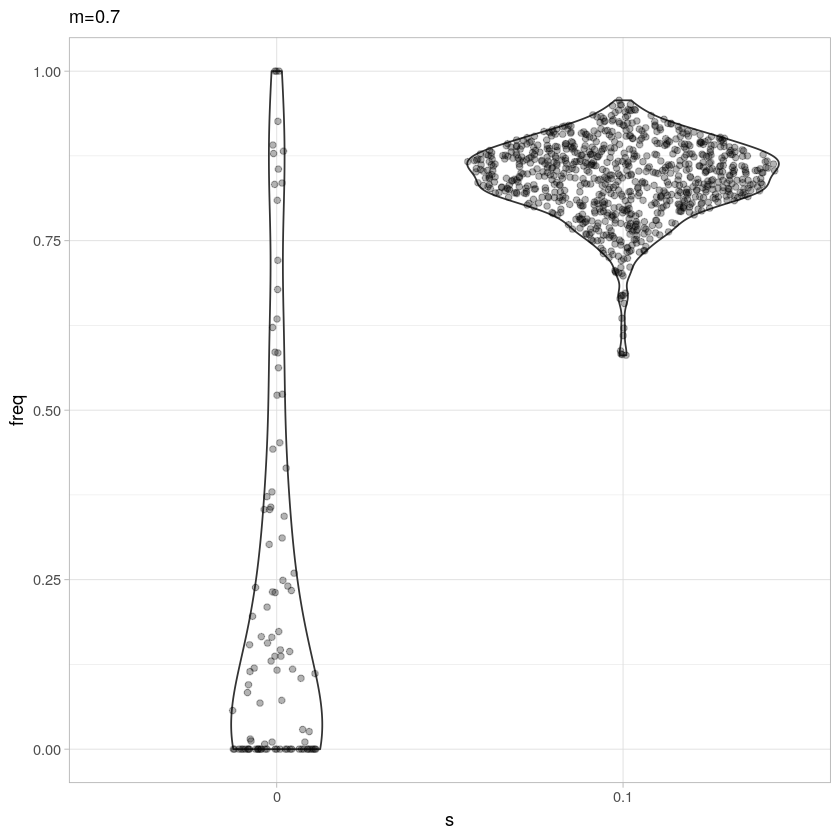

In [81]:
frequencies$s <- factor(frequencies$s)
frequencies %>% 
        filter(generation==max_gen) %>% 
        filter(pop=="p5") %>% 
        ggplot(aes(x=s, y=freq)) +
        labs(subtitle = paste0("m=",admixture_ratio)) +
        geom_violin(fill=NA) +
        geom_sina(alpha= 0.3) +
        ylim(c(0,1)) +
        theme_light()

`summarise()` has grouped output by 'replicate', 's'. You can override using the `.groups` argument.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



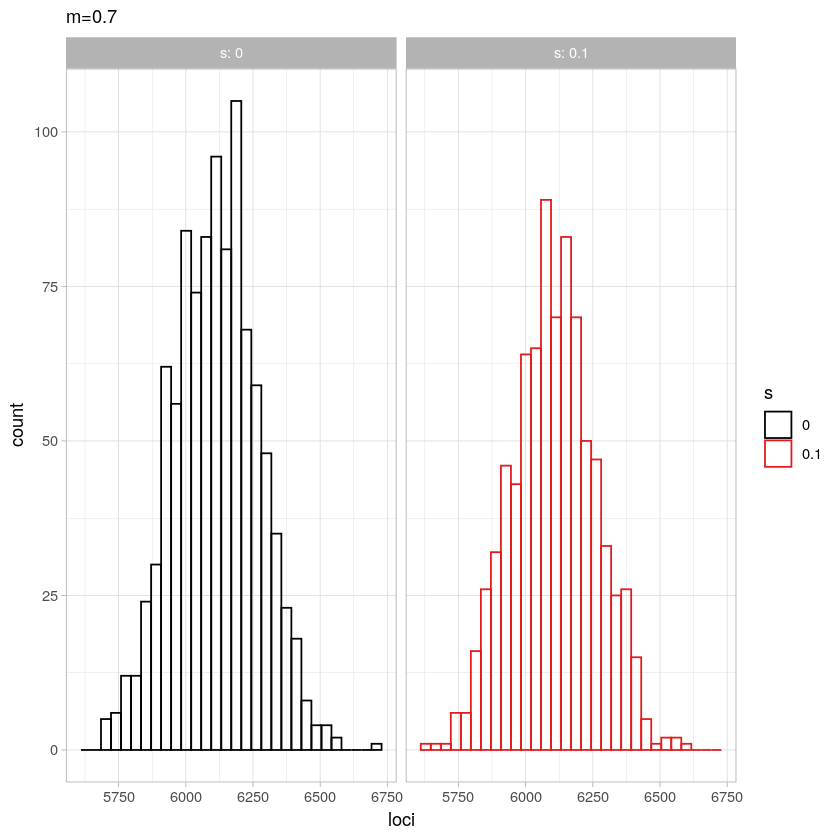

In [82]:
hapflk$s <- factor(hapflk$s)
hapflk %>%
        dplyr::select(pos, replicate,s,m)%>%
        distinct() %>%
        group_by(replicate,s,m) %>%
        summarise(loci=n()) %>%
        ggplot() +
        labs(subtitle = paste0("m=",admixture_ratio)) +
        geom_histogram(aes(x=loci, color = s), fill= NA) +
        wrap_by(s) +
        theme_light() +
        scale_color_manual(values=c( "black", "#e31a1c"))

In [83]:
reps <- hapflk %>%
        dplyr::select(replicate, s,m) %>%
        distinct() %>%
        mutate(replicate=factor(replicate)) %>%
        group_by(s,m) %>%
        summarise(analysed_simulations=n())

`summarise()` has grouped output by 's'. You can override using the `.groups` argument.



In [84]:
reps

s,m,analysed_simulations
<fct>,<dbl>,<int>
0,0.7,1000
0.1,0.7,826


Warning message:
“Removed 3700412 rows containing missing values (geom_point).”


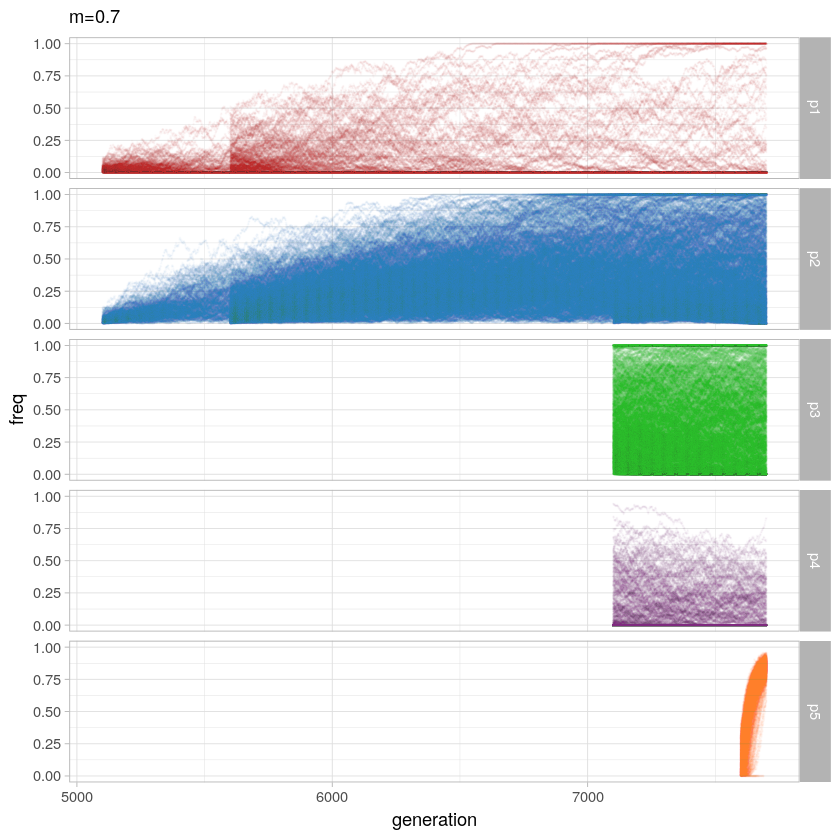

In [85]:
plotFrequencies(frequencies,scoef = 0.1,mcoef = as.numeric(admixture_ratio))

### Power and frequency at selection onset

In [151]:
mcoef <- as.numeric(admixture_ratio) 

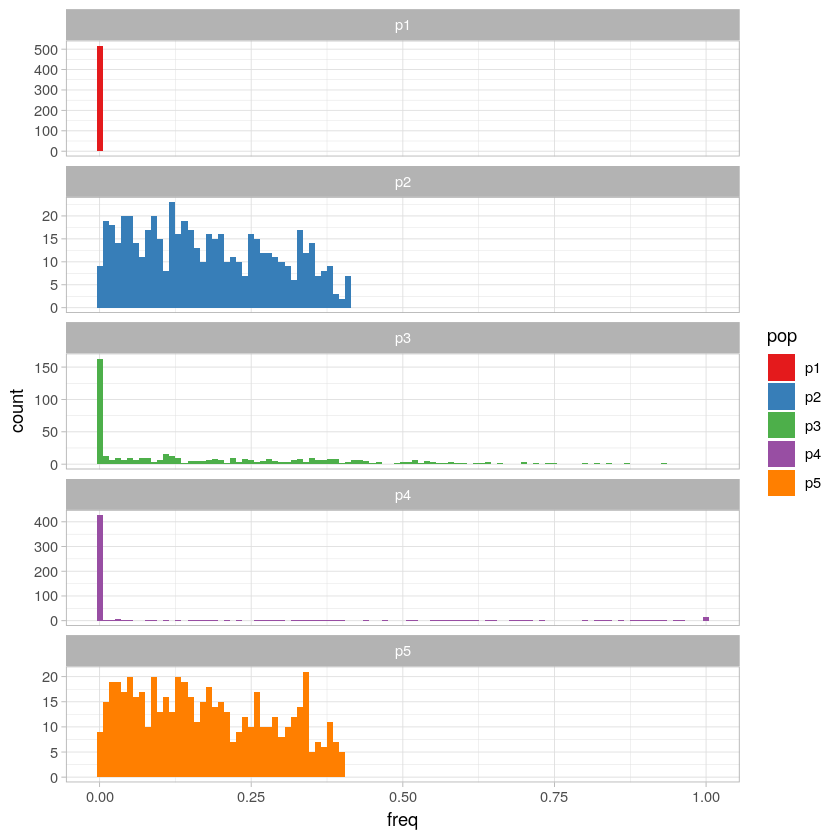

In [152]:
frequencies %>%
    filter(m==mcoef&s==0.1) %>%
    filter(generation==7600) %>%
    ggplot(aes(x=freq, fill=pop)) +
    geom_histogram(binwidth = 0.01) +
    theme_light() + 
    facet_wrap(~pop, scales="free_y", ncol =1)+
    scale_fill_manual(values=popcolors)

### Divide in frequency sections

In [116]:
freqPWR<- function( d ,frequencies, mcoef, min_freq ,max_freq){
    # get hapflk in a certain frequency window
    selected <- frequencies %>% filter(generation==7600) %>%  
                    filter(s==0.1,m==mcoef) %>%
                    filter(freq<=max_freq&freq>min_freq&pop=="p5") %>% 
                    select(replicate,s,m)  %>%
                    distinct()%>%
                    left_join(d)
    # total number of replicates for computing ROC
    
    total_replicates <- selected %>% 
                        select(replicate) %>%
                        distinct() %>% 
                        pull() %>% 
                        length()
    # get null distribution of hapflk (no selection)
    null <- d %>%
        filter(s==0, m==mcoef)
    # join two dfs together
    newdf <- full_join(selected,null)
    # compute ROC
    pW <- computeROC(newdf,mcoef) %>%
            mutate(replicates=total_replicates,
                  minfrq=min_freq,
                  maxfrq=max_freq) %>% mutate(m=mcoef)

    # return total replicates
    pW
}

In [117]:
pwr <- freqPWR(hapflk,frequencies,mcoef,min_freq=0, max_freq=0.1)

Joining, by = c("replicate", "s", "m")

Joining, by = c("replicate", "s", "m", "pos", "hapflk", "covariance")

`summarise()` has grouped output by 'replicate', 'covariance'. You can override using the `.groups` argument.

Adding missing grouping variables: `replicate`



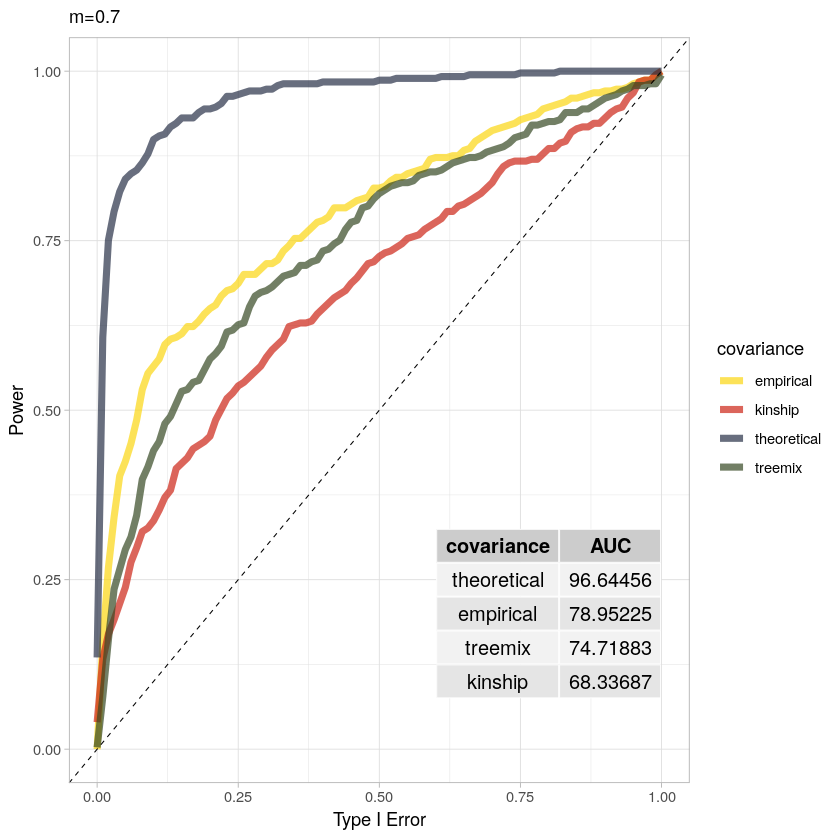

In [118]:
plotROC(pwr, mcoef)

#### Power vs frequency in covariance

In [15]:
PowerRanger <- function(hapflk, frequencies, admixture_ratio, tholds=c(0,0.01,0.05,0.1,0.2,0.3,0.4)){
    
    for (i in 2:length(tholds)){
    
    if (i==2){
    pwr <- freqPWR(hapflk,
                   frequencies, 
                   mcoef=admixture_ratio,
                   max_freq=tholds[i],
                   min_freq=tholds[i-1])
    } else {
        pwr <-  freqPWR(hapflk,
                frequencies, 
                mcoef=admixture_ratio,
                max_freq=tholds[i],
                min_freq=tholds[i-1]) %>%
                full_join(.,pwr)
    }
    
    
}
    pwr
}

#### Compute power for all migration coefficients (TAKES TIME)

In [16]:
mcoefs <- c("0.0","0.3","0.7") 

In [17]:
i <- 1

In [18]:
DF <- read_hapflk(admixture_ratio=mcoefs[i])
hapflk <- DF$hapflk
frequencies <- DF$frequencies
tmp1 <- PowerRanger(hapflk, frequencies, admixture_ratio=as.numeric(mcoefs[i]))


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  rs = col_character(),
  chr = col_double(),
  pos = col_double(),
  hapflk = col_double(),
  K = col_double(),
  covariance = col_character(),
  replicate = col_double()
)



── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  rs = col_character(),
  chr = col_double(),
  pos = col_double(),
  hapflk = col_double(),
  K = col_double(),
  covariance = col_character(),
  replicate = col_double()
)


Joining, by = c("chr", "pos", "hapflk", "covariance", "replicate", "m", "s")


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  generation = col_double(),
  pop = col_character(),
  freq = col_double(),
  s = col_double(),
  m =

In [19]:
i <- 2

In [20]:
DF <- read_hapflk(admixture_ratio=mcoefs[i])
hapflk <- DF$hapflk
frequencies <- DF$frequencies
tmp2 <- PowerRanger(hapflk, frequencies, admixture_ratio=as.numeric(mcoefs[i]))


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  rs = col_character(),
  chr = col_double(),
  pos = col_double(),
  hapflk = col_double(),
  K = col_double(),
  covariance = col_character(),
  replicate = col_double()
)



── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  rs = col_character(),
  chr = col_double(),
  pos = col_double(),
  hapflk = col_double(),
  K = col_double(),
  covariance = col_character(),
  replicate = col_double()
)


Joining, by = c("chr", "pos", "hapflk", "covariance", "replicate", "m", "s")


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  generation = col_double(),
  pop = col_character(),
  freq = col_double(),
  s = col_double(),
  m =

In [21]:
i <- 3

In [22]:
DF <- read_hapflk(admixture_ratio=mcoefs[i])
hapflk <- DF$hapflk
frequencies <- DF$frequencies
tmp3 <- PowerRanger(hapflk, frequencies, admixture_ratio=as.numeric(mcoefs[i]))


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  rs = col_character(),
  chr = col_double(),
  pos = col_double(),
  hapflk = col_double(),
  K = col_double(),
  covariance = col_character(),
  replicate = col_double()
)



── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  rs = col_character(),
  chr = col_double(),
  pos = col_double(),
  hapflk = col_double(),
  K = col_double(),
  covariance = col_character(),
  replicate = col_double()
)


Joining, by = c("chr", "pos", "hapflk", "covariance", "replicate", "m", "s")


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  generation = col_double(),
  pop = col_character(),
  freq = col_double(),
  s = col_double(),
  m =

In [23]:
rm(DF)

In [24]:
all_pwr <- full_join(tmp1,tmp2) %>% full_join(., tmp3)

Joining, by = c("alpha", "covariance", "power", "replicates", "minfrq", "maxfrq", "m")

Joining, by = c("alpha", "covariance", "power", "replicates", "minfrq", "maxfrq", "m")



In [25]:
write_delim(all_pwr,"all_pwr.tsv", delim = "\t")

In [79]:
all_pwr <- read_delim("all_pwr.tsv", delim = "\t")


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  alpha = col_double(),
  covariance = col_character(),
  power = col_double(),
  replicates = col_double(),
  minfrq = col_double(),
  maxfrq = col_double(),
  m = col_double()
)




`summarise()` has grouped output by 'covariance', 'power', 'replicates', 'm'. You can override using the `.groups` argument.



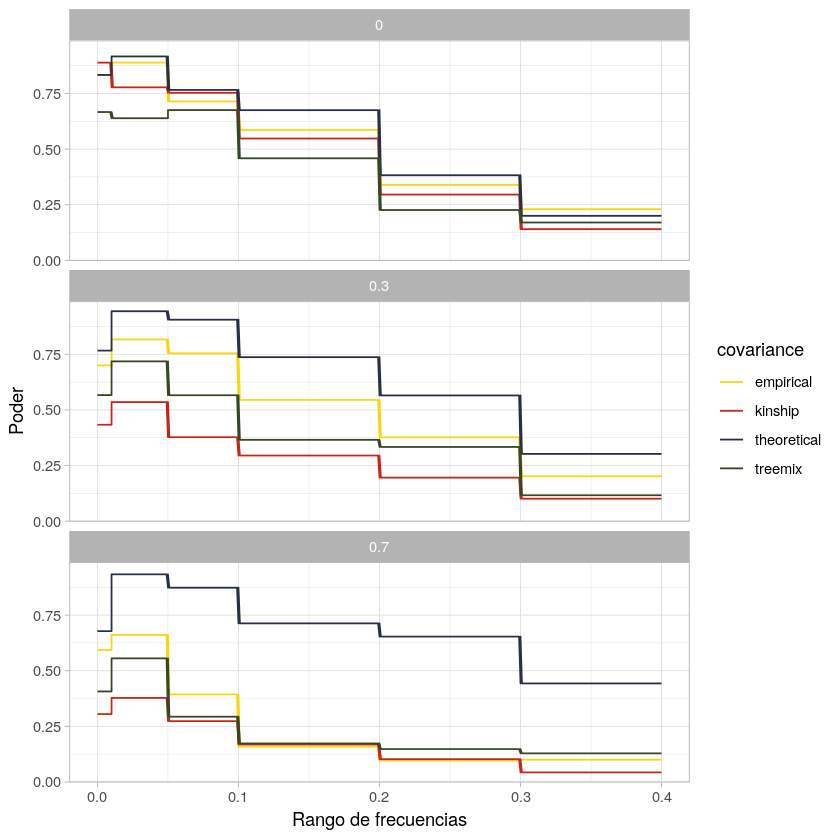

In [80]:
all_pwr %>% 
filter(alpha==0.1) %>%
group_by(covariance, power,replicates,m) %>% 
summarise(f=seq(from = minfrq, to=maxfrq, by=0.001)) %>% 
ggplot(aes(x=f,y=power, color = covariance))+
        geom_line() +
        facet_wrap(~m, ncol=1) +
        theme_light() +
        scale_color_manual(values=colors) +
        xlim(0,0.4) +
        ylab("Poder") +
        xlab("Rango de frecuencias")

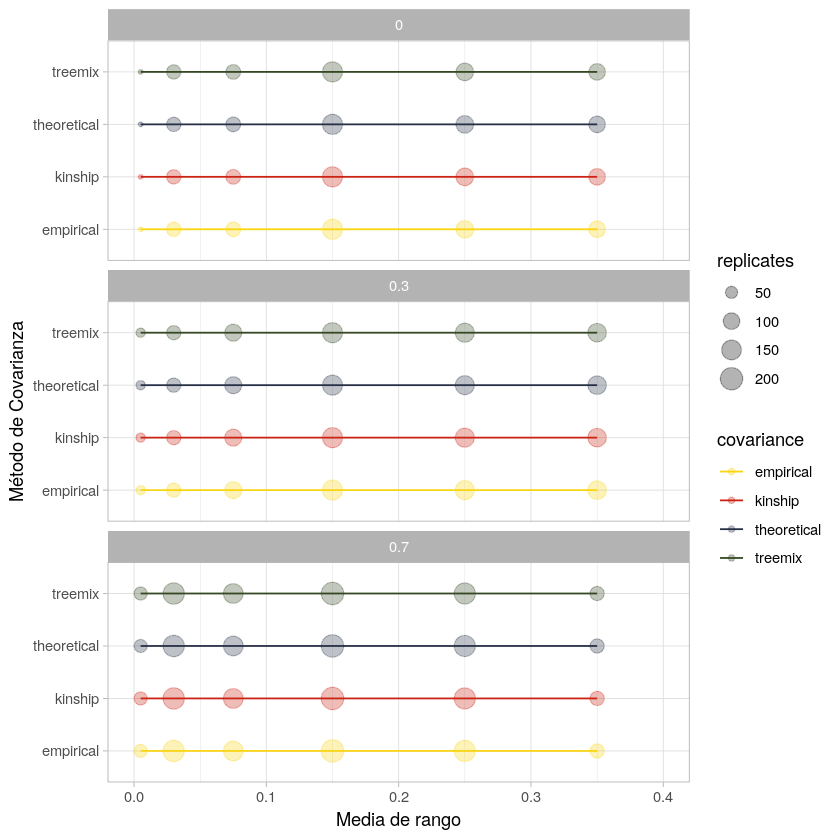

In [82]:
 all_pwr %>% 
filter(alpha==0.01) %>%
group_by(covariance,power,replicates,m) %>%
mutate(avg_f=mean(c(minfrq,maxfrq))) %>%
    ggplot(aes(x=avg_f,y=covariance, color = covariance))+
        geom_point(aes(size=replicates), alpha=0.3) +
        facet_wrap(~m, ncol=1) +
        geom_line()+
        theme_light() +
        scale_color_manual(values=colors) +
        xlim(0,0.4)+
        xlab("Media de rango") +
        ylab("Método de Covarianza")

### P-value computation

Computar p-valores con reescalado de chi cuadrado y visualizar histogramas por frecuencia alélica.

In [11]:
K <- 10
n <- 4

In [12]:
hapflk_df <- (n-1)*(K-1)

In [13]:
# function for computing scaled values
qReg <- function(x, probs = seq(0,1-0.01,0.01),df){
    # Compute empirical quantiles
    eq <- quantile(x, probs=probs)
    # Compute theoretical quantiles
    tq  <- qchisq(probs, df=df ) 
    # Fit a robust linear model
    fit  <- MASS::rlm(tq~eq, maxit=100)
    # Get coefficients
    b <- fit$coefficients[1]
    a <- fit$coefficients[2]
    # Return scaled values
    y_hat <- x*a + b
    return(y_hat)
}

In [14]:
head(hapflk)


replicate,s,m,pos,hapflk,covariance
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1000,0,0,3261,0.5191879,theoretical
1000,0,0,4169,0.5191926,theoretical
1000,0,0,4517,0.5191976,theoretical
1000,0,0,6298,0.6814521,theoretical
1000,0,0,7603,0.6815076,theoretical
1000,0,0,11688,0.7630436,theoretical


In [53]:
qvals <- hapflk %>%
    group_by(replicate, covariance, s,m) %>%
    rename(unscaled="hapflk") %>%
    mutate(scaled=qReg(unscaled, df = hapflk_df) ) %>%
    pivot_longer(cols = c("unscaled", "scaled"),
                 names_to = "scaling",
                 values_to = "hapflk" ) %>%
    group_by(replicate,covariance,scaling, s,m) %>%
    mutate(pval = 1- pchisq(hapflk, df = hapflk_df ) ) %>%
    mutate(qval = p.adjust(pval, method = "fdr" ) ) %>%
    ungroup()

In [16]:
head(qvals)

replicate,s,m,pos,covariance,scaling,hapflk,pval,qval
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1000,0,0,3261,theoretical,unscaled,0.5191879,1.0000000,1.0000000
1000,0,0,3261,theoretical,scaled,9.6451783,0.9991372,0.9999928
1000,0,0,4169,theoretical,unscaled,0.5191926,1.0000000,1.0000000
1000,0,0,4169,theoretical,scaled,9.6452400,0.9991371,0.9999928
1000,0,0,4517,theoretical,unscaled,0.5191976,1.0000000,1.0000000
1000,0,0,4517,theoretical,scaled,9.6453054,0.9991371,0.9999928


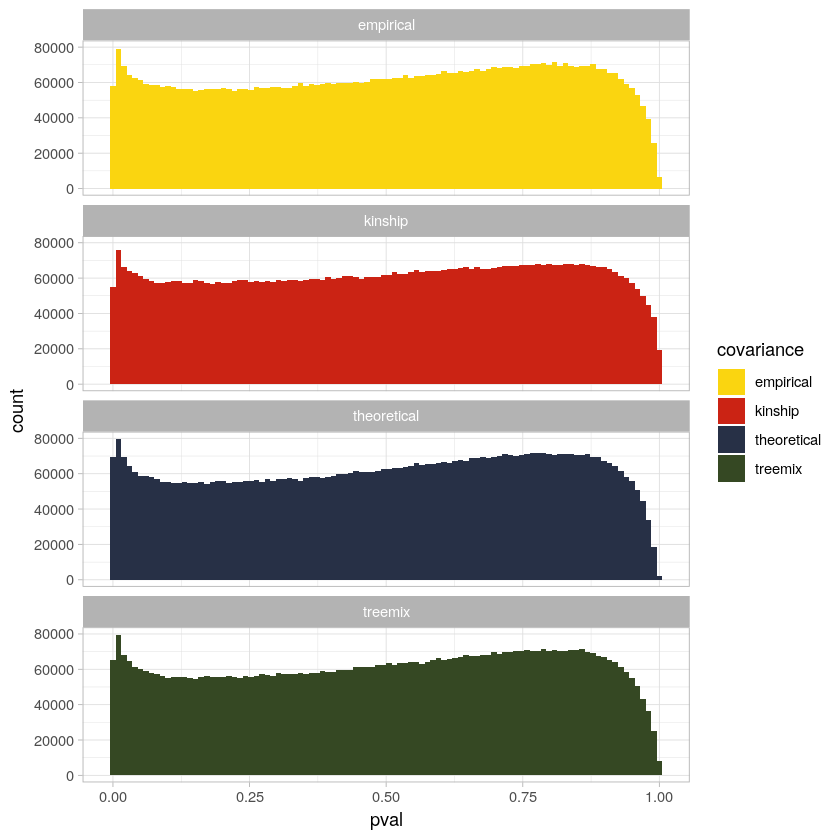

In [54]:
qvals %>% filter(s==0,scaling=="scaled") %>%
ggplot(aes(x=pval)) +
geom_histogram(aes(fill=covariance),bins=100) +
facet_wrap(~covariance,ncol=1) +
theme_light()+
scale_fill_manual(values=colors) 


Filter low frequency alleles at selection onset

In [55]:
maxf1 <- frequencies %>%
filter(generation==7600, pop=="p5",s==0.1) %>%
filter(freq>=0, freq<0.1) %>%
select(replicate,s,m) %>% 
left_join(., qvals) 

Joining, by = c("replicate", "s", "m")



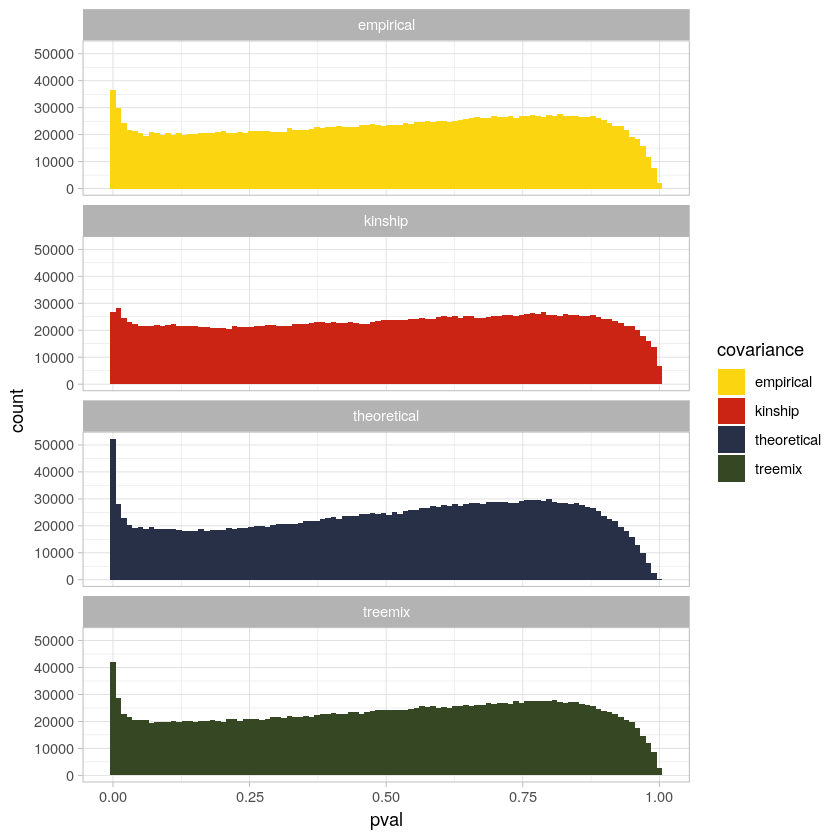

In [56]:
maxf1 %>% filter(scaling=="scaled") %>%
ggplot(aes(x=pval)) +
geom_histogram(aes(fill=covariance),bins=100) +
facet_wrap(~covariance,ncol=1) +
theme_light()+
scale_fill_manual(values=colors) 

#### Manhattan plots

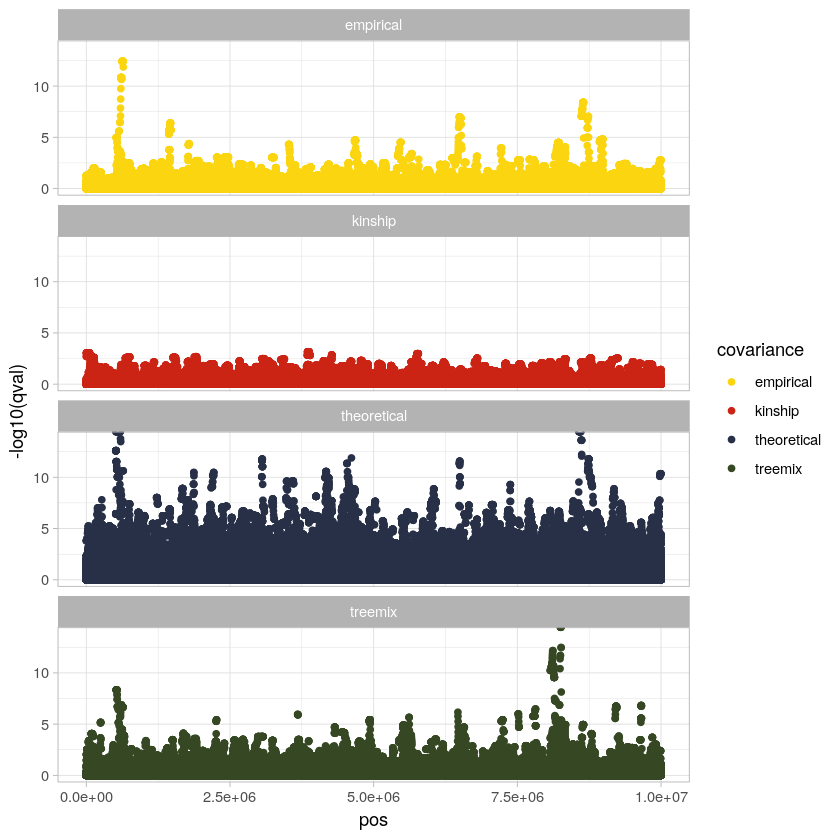

In [77]:
qvals %>% filter(s==0) %>%
ggplot(aes(x=pos,y=-log10(qval), color = covariance)) +
geom_point() +
facet_wrap(~covariance, ncol=1)+
scale_color_manual(values=colors) +
theme_light()

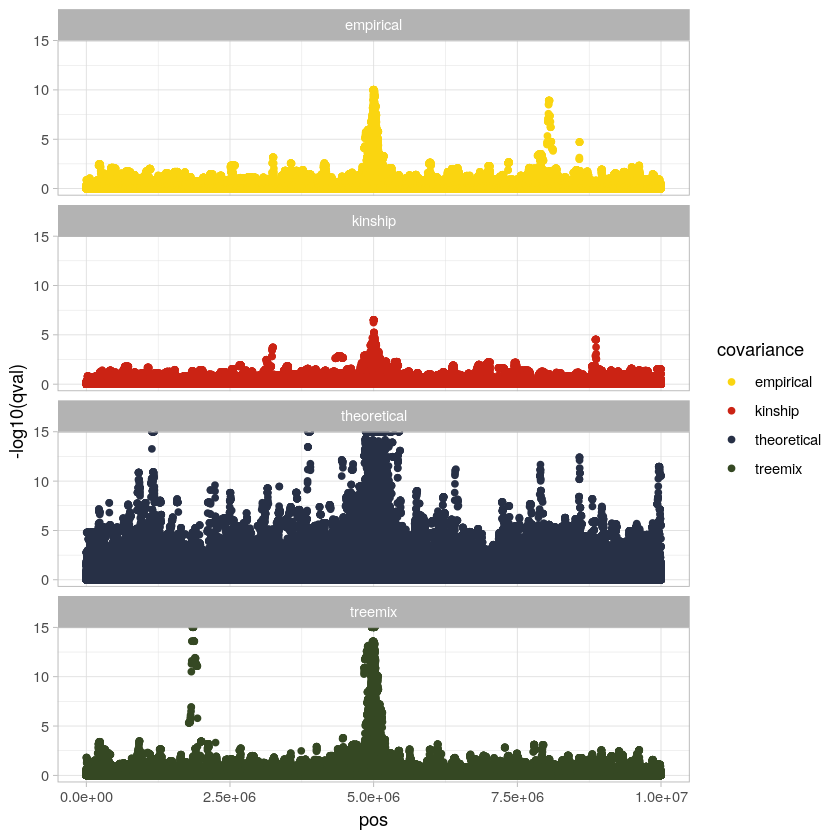

In [75]:
maxf1  %>%
ggplot(aes(x=pos,y=-log10(qval), color = covariance)) +
geom_point() +
facet_wrap(~covariance, ncol=1)+
scale_color_manual(values=colors)  +
theme_light()